In [2]:
# This mounts your Google Drive to the Colab VM.
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
DATA_PATH = "/Users/hyunwoo/Downloads/Jobcare_data"
SUBMIT_PATH = '/Users/hyunwoo/Downloads/Jobcare_data'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# install tabnet
!pip install pytorch_tabnet

In [124]:
!pip install Light_Famd
from Light_Famd import CA

ModuleNotFoundError: No module named 'Light_Famd'

In [3]:
!pip install prince
import prince
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
from typing import Dict

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 라이브러리 설치
import warnings                                      # 경고 메세지 무시
warnings.filterwarnings('ignore')
import random                                        # 난수 생성
random.seed(2020)
random_seed = 2020
import time                                          # 시간 측정
import re                                            # 정규표현식

from sklearn.model_selection import train_test_split # train, validation 데이터 나누기
from sklearn import metrics                          # AUC 측정
!pip install catboost
from catboost import CatBoostClassifier, Pool        # CatBoost 모델링
from sklearn.model_selection import KFold            # K-fold CV    
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization           # 베이지안 최적화 라이브러리  
from functools import partial                        # 함수 변수 고정

In [240]:
df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_test  = pd.read_csv(DATA_PATH + '/test.csv')

In [241]:
d_code = pd.read_csv(DATA_PATH + '/att_D.csv', index_col=0).T.to_dict()
h_code = pd.read_csv(DATA_PATH + '/att_H.csv', index_col=0).T.to_dict()
l_code = pd.read_csv(DATA_PATH + '/att_L.csv', index_col=0).T.to_dict()

def add_code(
    df: pd.DataFrame,
    d_code: Dict[int, Dict[str, int]], 
    h_code: Dict[int, Dict[str, int]], 
    l_code: Dict[int, Dict[str, int]],
) -> pd.DataFrame:
    
    # Copy input data
    df = df.copy()   

    # D Code
    df['person_prefer_d_1_n'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_1_s'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_1_m'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_1_l'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_2_n'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_2_s'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_2_m'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_2_l'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_3_n'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_3_s'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_3_m'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_3_l'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['contents_attribute_d_n'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['contents_attribute_d_s'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['contents_attribute_d_m'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['contents_attribute_d_l'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    # H Code
    df['person_prefer_h_1_l'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_1_m'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_2_l'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_2_m'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_3_l'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_3_m'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    df['contents_attribute_h_l'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['contents_attribute_h_m'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    # L Code
    df['contents_attribute_l_n'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 세분류코드'])
    df['contents_attribute_l_s'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 소분류코드'])
    df['contents_attribute_l_m'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 중분류코드'])
    df['contents_attribute_l_l'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 대분류코드'])
    
    return df

df_train = add_code(df_train, d_code, h_code, l_code)
df_test  = add_code(df_test, d_code, h_code, l_code)
# 35에서 63으로 column 개수 증가


In [242]:

contentsrn = df_train['contents_rn'].value_counts()
contentsrn2 = df_test['contents_rn'].value_counts()
ct = df_train['person_rn'].value_counts()
ct2 = df_test['person_rn'].value_counts()
df_train['person_count'] = df_train['person_rn'].apply(lambda x: ct[x])
df_test['person_count'] = df_test['person_rn'].apply(lambda x: ct2[x])
df_train['contents_count'] = df_train['contents_rn'].apply(lambda x: contentsrn[x])
df_test['contents_count'] = df_test['contents_rn'].apply(lambda x: contentsrn2[x])


In [243]:
df_train.loc[:,['contents_count', 'target']].groupby(by=['contents_count']).mean('target')


,target
contents_count,
1,0.402177
2,0.476306
3,0.536793
4,0.588552
5,0.615681
6,0.650326
7,0.666541
8,0.694022
9,0.701925


In [244]:
df_train['Hour'] = pd.to_datetime(df_train['contents_open_dt']).dt.hour 
df_train['day'] = pd.to_datetime(df_train['contents_open_dt']).dt.dayofweek
df_test['Hour'] = pd.to_datetime(df_test['contents_open_dt']).dt.hour 
df_test['day']= pd.to_datetime(df_test['contents_open_dt']).dt.dayofweek 

In [245]:
'''
##########################/ 09~19 , 19~01 , 01~09  / 0,1,2
for i in range(len(df_train)):
  if df_train['Hour'][i] >= 1 and df_train['Hour'][i]<9:
    df_train['Hour'][i] = 0
  elif df_train['Hour'][i] >=9 and df_train['Hour'][i]<19:
    df_train['Hour'][i] = 1
  else:
    df_train['Hour'][i] = 2 

for i in range(len(df_test)):
  if df_test['Hour'][i] >= 1 and df_test['Hour'][i]<9:
    df_test['Hour'][i] = 0
  elif df_test['Hour'][i] >=9 and df_test['Hour'][i]<19:
    df_test['Hour'][i] = 1
  else:
    df_test['Hour'][i] = 2 
    
############################################ 월~금=0 , 토~일 = 1 
for i in range(len(df_train)):
  if df_train['day'][i] < 5:
    df_train['day'][i] = 1
  else:
    df_train['day'][i] = 0

for i in range(len(df_test)):
  if df_test['day'][i] <5:
    df_test['day'][i] = 1
  else:
    df_test['day'][i] = 0
'''

"\n##########################/ 09~19 , 19~01 , 01~09  / 0,1,2\nfor i in range(len(df_train)):\n  if df_train['Hour'][i] >= 1 and df_train['Hour'][i]<9:\n    df_train['Hour'][i] = 0\n  elif df_train['Hour'][i] >=9 and df_train['Hour'][i]<19:\n    df_train['Hour'][i] = 1\n  else:\n    df_train['Hour'][i] = 2 \n\nfor i in range(len(df_test)):\n  if df_test['Hour'][i] >= 1 and df_test['Hour'][i]<9:\n    df_test['Hour'][i] = 0\n  elif df_test['Hour'][i] >=9 and df_test['Hour'][i]<19:\n    df_test['Hour'][i] = 1\n  else:\n    df_test['Hour'][i] = 2 \n    \n############################################ 월~금=0 , 토~일 = 1 \nfor i in range(len(df_train)):\n  if df_train['day'][i] < 5:\n    df_train['day'][i] = 1\n  else:\n    df_train['day'][i] = 0\n\nfor i in range(len(df_test)):\n  if df_test['day'][i] <5:\n    df_test['day'][i] = 1\n  else:\n    df_test['day'][i] = 0\n"

In [246]:
df_train.loc[:,['Hour', 'target']].groupby(by=['Hour']).mean('target')



,target
Hour,
0,0.469570
1,0.444165
2,0.441021
3,0.456365
4,0.440096
5,0.452622
6,0.473348
7,0.495428
8,0.523567


<AxesSubplot:>

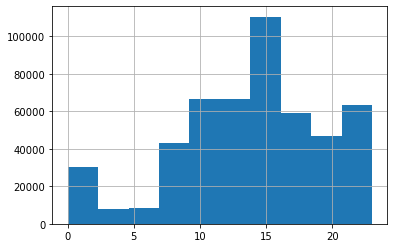

In [247]:
df_train['Hour'].hist()

<AxesSubplot:>

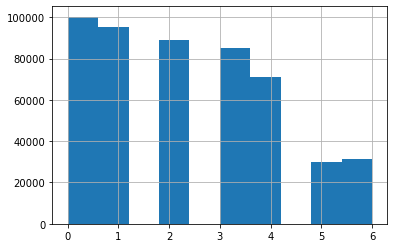

In [248]:
df_train['day'].hist()

In [249]:
# 일단 id, person_rn, contents_open_dt 를 제거해야하는가? person_rn과 contents_rn 이 같은값을 가지는아이가 있음
df_train = df_train.drop(['id','person_prefer_f','person_prefer_g','contents_rn','person_rn','contents_open_dt'], axis=1)
df_test  = df_test.drop(['id','person_prefer_f','person_prefer_g','contents_rn','person_rn','contents_open_dt'], axis=1)
#df_train = df_train.drop(['id','person_prefer_f','person_prefer_g','contents_open_dt'], axis=1)
#df_test  = df_test.drop(['id','person_prefer_f','person_prefer_g','contents_open_dt'], axis=1)


In [250]:
# 제대로 제거됐나 확인
print(df_train.columns)
print(df_test.columns)
print(len(df_train.columns))

Index(['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2',
       'person_prefer_h_3', 'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'target', 'person_prefer_d_1_n',
       'person_prefer_d_1_s', 'person_prefer_d_1_m', 'person_prefer_d_1_l',
       'person_prefer_d_2_n', 'person_prefer_d_2_s', 'person_prefer_d_2_m',
       'person_prefer_d_2_l', 'person_prefer_d_3_n', 'person_prefer_d_3_s',
       'person_prefer_d_3_m', 'person_prefer_d_3_l', 'contents_attribute_d_

In [251]:
# data를 train, valid, test로 나누기
if "Set" not in df_train.columns:
    df_train["Set"] = np.random.choice(["train",'valid'], p =[0.9,0.1], size=(df_train.shape[0],))

train_indices = df_train[df_train.Set=="train"].index
valid_indices = df_train[df_train.Set=="valid"].index
#test_indices = df_train[df_train.Set=="test"].index

In [252]:
ordinal = []#['person_count','contents_count','person_attribute_a_1', 'person_attribute_b', 'person_prefer_e', 'contents_attribute_e']

categorical_columns = []
categorical_dims =  {}
for col in df_train.columns:
    if col not in ordinal+['Set', 'target']:
        print(col, df_train[col].nunique())
        l_enc = LabelEncoder()
        df_train[col] = l_enc.fit_transform(df_train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
        df_test[col]  = l_enc.fit_transform(df_test[col].values)

d_l_match_yn 2
d_m_match_yn 2
d_s_match_yn 2
h_l_match_yn 2
h_m_match_yn 2
h_s_match_yn 2
person_attribute_a 2
person_attribute_a_1 8
person_attribute_b 6
person_prefer_c 5
person_prefer_d_1 1093
person_prefer_d_2 1081
person_prefer_d_3 1043
person_prefer_e 12
person_prefer_h_1 279
person_prefer_h_2 279
person_prefer_h_3 279
contents_attribute_i 3
contents_attribute_a 3
contents_attribute_j_1 9
contents_attribute_j 2
contents_attribute_c 4
contents_attribute_k 2
contents_attribute_l 1752
contents_attribute_d 1065
contents_attribute_m 5
contents_attribute_e 12
contents_attribute_h 250
person_prefer_d_1_n 443
person_prefer_d_1_s 137
person_prefer_d_1_m 36
person_prefer_d_1_l 11
person_prefer_d_2_n 435
person_prefer_d_2_s 137
person_prefer_d_2_m 36
person_prefer_d_2_l 11
person_prefer_d_3_n 420
person_prefer_d_3_s 136
person_prefer_d_3_m 36
person_prefer_d_3_l 11
contents_attribute_d_n 431
contents_attribute_d_s 137
contents_attribute_d_m 36
contents_attribute_d_l 11
person_prefer_h_1_l 1

In [253]:
unused_feat = ['Set']

features = [ col for col in df_train.columns if col not in unused_feat+['target']] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [162]:
'''       PCA 
mca = prince.MCA(
    n_components=5,
    random_state=2022,
    n_iter=15
)
mca.fit(df_train[features])
main_mca = mca.transform(df_train[features])
df_test = mca.transform(df_test)
'''


In [163]:
#[i/sum(mca.eigenvalues_) for i in mca.eigenvalues_]##### 5개 사용이 좋아보임
 

[0.6808080832994885,
 0.22062658963457993,
 0.062048424877434234,
 0.02231845157060019,
 0.014198450617897188]

In [164]:
#print(len(main_mca.columns),len(df_test.columns))

5 5


# Training


In [254]:
####################################### CATBOOST
X_train = df_train[features].iloc[train_indices]
y_train = df_train['target'].iloc[train_indices]

X_valid = df_train[features].iloc[valid_indices]
y_valid = df_train['target'].iloc[valid_indices]


X_test = df_train[features].iloc[test_indices]
y_test = df_train['target'].iloc[test_indices]


################################ tabnet
#X_train = df_train[features].values[train_indices]
#y_train = df_train['target'].values[train_indices]
#X_valid = df_train[features].values[valid_indices]
#y_valid = df_train['target'].values[valid_indices]

#X_test = df_train[features].values[test_indices]
#y_test = df_train['target'].values[test_indices]


'''
X_train = main_mca.values[train_indices]
y_train = df_train['target'].values[train_indices]


X_valid = main_mca.values[valid_indices]
y_valid = df_train['target'].values[valid_indices]

X_test = main_mca.values[test_indices]
y_test = df_train['target'].values[test_indices]

df_test = df_test.values
'''

"\nX_train = main_mca.values[train_indices]\ny_train = df_train['target'].values[train_indices]\n\n\nX_valid = main_mca.values[valid_indices]\ny_valid = df_train['target'].values[valid_indices]\n\nX_test = main_mca.values[test_indices]\ny_test = df_train['target'].values[test_indices]\n\ndf_test = df_test.values\n"

In [175]:
'''
N_D = 8    ### 8~64 , 높을수록 overfitting 위험 ㄴ
N_A = 8       ### N_D와 같게
N_INDEP = 2      ### 1~5
N_SHARED = 2      ### 1~5
N_STEPS = 3       ### 3~10

unsupervised_model = TabNetPretrainer(
    n_d=N_D, n_a=N_A, n_steps=N_STEPS,  #0.2,
    n_independent=N_INDEP, n_shared=N_SHARED,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-2,weight_decay=1e-5),
    mask_type='sparsemax' # "sparsemax",

)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    pretraining_ratio=0.8,
    patience=15, batch_size=2048, virtual_batch_size=128,
    num_workers=0 ,
    max_epochs=101
)

tabnet_params = dict(n_d=N_D, n_a=N_A, n_steps=N_STEPS,  #0.2,
                         n_independent=N_INDEP, n_shared=N_SHARED,
                         lambda_sparse=0., optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2, # 2e-2
                                               weight_decay=1e-5),
                          scheduler_params={'step_size':50, 'gamma':0.90},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,
                          mask_type="entmax",
                         
                          verbose=10,
                         )

pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(
    X_train=X_train,
    eval_set=[X_valid],
    pretraining_ratio=0.8,
    patience=15, batch_size=2048, virtual_batch_size=128,
    num_workers=0 ,
    max_epochs=101
)
'''

Device used : cpu
epoch 0  | loss: 3.08934 | val_0_unsup_loss: 0.9118  |  0:00:19s
epoch 10 | loss: 0.91131 | val_0_unsup_loss: 0.77462 |  0:03:32s
epoch 20 | loss: 0.90451 | val_0_unsup_loss: 0.80782 |  0:06:43s

Early stopping occurred at epoch 28 with best_epoch = 13 and best_val_0_unsup_loss = 0.76964
Best weights from best epoch are automatically used!


In [222]:
class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
    
    def __call__(self, y_true, y_score):
        score = f1_score(y_true, y_score[:,1]>0.5)
        return score

In [177]:
# setting hyperparameters tabnet
max_epochs = 100
patience = 15
batch_size = 2048
virtual_batch_size = 128
num_workers = 0
weights = 0

tabnet = TabNetClassifier(#cat_idxs=cat_idxs,
                          cat_idxs = list(range(0,len(main_mca.columns))),
#                          cat_dims=cat_dims,
                          n_d=N_D, n_a=N_A, n_steps=N_STEPS,
                         n_independent=N_INDEP, n_shared=N_SHARED,
                          optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=2e-2, # 2e-2
                                               weight_decay=1e-4),
                          scheduler_params={'step_size':15, 'gamma':0.90},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,
                          #scheduler_params=dict(mode="min",
                          #                      patience=5,
                          #                      min_lr=1e-5,
                          #                      factor=0.9,),
                          #scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau, 
                          mask_type='entmax', #'sparsemax',  라는 옵션도 있음
                          device_name=device
                          )



Device used : cpu


In [178]:
# fitting model tabnet
tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    #eval_set = [(X_valid,y_valid)],
    eval_name=['train','valid'],
    eval_metric=['auc','f1'],
    max_epochs=max_epochs, patience=patience,
    batch_size=batch_size, virtual_batch_size=virtual_batch_size,
    num_workers=num_workers,
    weights=weights,
    from_unsupervised=pretrainer,
    drop_last=False,
)


Loading weights from unsupervised pretraining
epoch 0  | loss: 0.68871 | train_auc: 0.55996 | train_f1: 0.65065 | valid_auc: 0.55748 | valid_f1: 0.64937 |  0:00:19s
epoch 1  | loss: 0.68683 | train_auc: 0.53381 | train_f1: 0.56405 | valid_auc: 0.5376  | valid_f1: 0.56337 |  0:00:39s
epoch 2  | loss: 0.68635 | train_auc: 0.53083 | train_f1: 0.52789 | valid_auc: 0.53264 | valid_f1: 0.52558 |  0:00:59s
epoch 3  | loss: 0.68634 | train_auc: 0.55924 | train_f1: 0.59542 | valid_auc: 0.55994 | valid_f1: 0.59109 |  0:01:19s
epoch 4  | loss: 0.68592 | train_auc: 0.56985 | train_f1: 0.64353 | valid_auc: 0.56414 | valid_f1: 0.63986 |  0:01:39s
epoch 5  | loss: 0.68571 | train_auc: 0.56169 | train_f1: 0.54531 | valid_auc: 0.5631  | valid_f1: 0.54142 |  0:01:59s
epoch 6  | loss: 0.68582 | train_auc: 0.56603 | train_f1: 0.60639 | valid_auc: 0.55925 | valid_f1: 0.59978 |  0:02:19s
epoch 7  | loss: 0.68566 | train_auc: 0.52734 | train_f1: 0.40662 | valid_auc: 0.52714 | valid_f1: 0.41013 |  0:02:39s
ep

In [179]:
################ tabnet
preds = tabnet.predict_proba(X_test)
test_auc = roc_auc_score(y_true=y_test, y_score=preds[:,1])
test_f1 = f1_score(y_test, preds[:,1]>0.4)
print(test_auc, test_f1)


0.5569100746674055 0.6674009402283412


In [180]:
######################### tabnet
f1=[]
for i in np.linspace(0,1,1001):
    f1.append(f1_score(y_test, preds[:,1]>i))
thres = np.linspace(0,1,1001)[f1.index(max(f1))]
print(max(f1) , thres)

0.6683462203342133 0.0


In [258]:

# CatBoost 모델링
def catboost_modeling(X_train, y_train, X_test, grow_policy, depth, learning_rate, l2_leaf_reg, random_seed, n):
  
  # 빈 Series인 test_pred 생성
  test_pred = pd.Series([0 for x in range(len(X_test))], index=X_test.index)
  
  # 10-fold 모델링을 n회 반복할 것
  for i in range(n):
    kf = KFold(n_splits=5, random_state=random_seed+i,shuffle=True)
    for train_index, valid_index in kf.split(X_train):
      train_X, train_y = X_train.iloc[train_index], y_train.iloc[train_index]
      valid_X, valid_y = X_train.iloc[valid_index], y_train.iloc[valid_index]
      
      # catBoost(grow_policy='Depthwise')
      model = CatBoostClassifier(eval_metric = 'F1',              # F1로 성능 측정
                                 iterations = 5000,               # 반복횟수 최대 5000
                                 #metric_period = 25000,            # 중간결과 출력X
                                 early_stopping_rounds = 200,     # 1000iteration 동안 F1 증가 없으면 학습 중단
                                 task_type = 'CPU',                # GPU/CPU 사용
                                 grow_policy = grow_policy,        # 트리 노드 생성 방식
                                                                   # 1) Depthwise(지정한 depth에 이를 때까지 level 순으로 노드 분할)
                                 cat_features = features,#<- Features          # 2) Lossguide(loss 변화가 큰 순으로 노드 분할)
                                 depth = depth,                    # 트리 깊이 4~10
                                 learning_rate = learning_rate,    # 러닝레이트
                                 l2_leaf_reg = l2_leaf_reg,        # L2 정규화
                                 random_seed = random_seed+i,      # 랜덤시드 고정
                                 )
      # 모델 학습
      model.fit(train_X, train_y, eval_set=(valid_X, valid_y),verbose=100)
    
      # 모델 적용
      test_pred += model.predict_proba(X_test)[:,1] /(5*n)
  # 설정된 디렉토리에 결과물 저장
  #submission = pd.read_csv(SUBMIT_PATH + '/sample_submission.csv',index_col=0)
  #submission = pd.DataFrame(data=test_pred, columns=sample_submission.columns, index=sample_submission.index)
  #submission.to_csv(SUBMIT_PATH + '/CatBoost_'+grow_policy+'_'+str(depth)+'.csv', index=True)

  return test_pred
  

In [259]:
data1 = catboost_modeling(X_train, y_train, df_test, 'SymmetricTree', 
                          depth=3, learning_rate=4e-02, l2_leaf_reg=None, random_seed = 2022,n=2)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6487533	test: 0.6515949	best: 0.6515949 (0)	total: 667ms	remaining: 55m 33s
100:	learn: 0.6318919	test: 0.6403694	best: 0.6517182 (4)	total: 35s	remaining: 28m 17s
200:	learn: 0.6435989	test: 0.6549996	best: 0.6550741 (198)	total: 1m 9s	remaining: 27m 46s
300:	learn: 0.6485420	test: 0.6606388	best: 0.6606388 (300)	total: 1m 44s	remaining: 27m 15s
400:	learn: 0.6525006	test: 0.6651616	best: 0.6651616 (400)	total: 2m 19s	remaining: 26m 43s
500:	learn: 0.6554487	test: 0.6688513	best: 0.6689485 (491)	total: 2m 52s	remaining: 25m 51s
600:	learn: 0.6574613	test: 0.6718551	best: 0.6719692 (587)	total: 3m 26s	remaining: 25m 9s
700:	learn: 0.6595422	test: 0.6729914	best: 0.6730393 (696)	total: 4m	remaining: 24m 36s
800:	learn: 0.6612467	test: 0.6745401	best: 0.6745401 (800)	total: 4m 36s	remaining: 24m 7s
900:	learn: 0.6622708	test: 0.6757058	best: 0.6757475 (896)	total: 5m 11s	remaining: 23m 37s
1000:	learn: 0.6630235	test: 0.6768809	best: 0.6768809 (1000)	total: 5m 46s	remaining: 

In [263]:
submission = pd.read_csv(SUBMIT_PATH + '/sample_submission.csv')
submission['target'] = (data1> 0.3)*1

submission.to_csv(SUBMIT_PATH + '/result.csv', index=False)



0        0.496253
1        0.355875
2        0.421571
3        0.458768
4        0.453540
           ...   
46399    0.534414
46400    0.470199
46401    0.572365
46402    0.576690
46403    0.589292
Length: 46404, dtype: float64

In [164]:

# 코드제출

preds = tabnet.predict_proba(df_test)

submission = pd.read_csv(SUBMIT_PATH + '/sample_submission.csv')
submission['target'] = (preds[:,1] > thres)*1

submission.to_csv(SUBMIT_PATH + '/tabnet_thres=' + str(thres) +'_f1='+str(max(f1))+ '.csv', index=False)


RuntimeError: running_mean should contain 62 elements not 32